# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version = '16'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="rimedsnow"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 2150090)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 17:34:22 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_s  = xr.open_dataset(fname).q_rimedsnow.values
    n_s  = xr.open_dataset(fname).n_rimedsnow.values
    rime_s = xr.open_dataset(fname).rime_rimedsnow.values
    rvol_s = xr.open_dataset(fname).rvol_rimedsnow.values
    liq_s  = xr.open_dataset(fname).liq_rimedsnow.values
    # process rates
    melt_liq = xr.open_dataset(fname).melt_rimedsnow_mass.values   # this is the total ice->liq rate
    # rescale process rate with temperature 
    t_3 = 273.15
    melt_liq= np.where(temp > t_3, melt_liq/(temp-t_3), np.nan)
    # some numerical lower bounds
    q_min = 1e-15
    n_min = 1e-15
    z_min = 1e-20
    p_min = 1e-20
    # use liquid water fraction (no log transform for this)
    liq_s = np.where(q_s>q_min,liq_s/q_s,np.nan)  
    liq_s = np.where(liq_s<0,np.nan,liq_s)  
    # transform everything in log space
    q_s = np.log(q_s, where=q_s>q_min, out=np.nan*q_s)
    n_s = np.log(n_s, where=n_s>n_min, out=np.nan*n_s)
    rime_s = np.log(rime_s, where=rime_s>q_min, out=np.nan*n_s)
    rvol_s = np.log(rvol_s, where=rvol_s>q_min, out=np.nan*n_s)
    melt_liq   = np.log(melt_liq,  where=melt_liq>p_min,  out=np.nan*melt_liq)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_s, n_s, rime_s, rvol_s, liq_s, melt_liq ]))
    dataset = dataset.T
    dataset.columns = [ 'q_s', 'num_s', 'rime_s', 'rvol_s', 'liq_s', 'melt_liq' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


In [8]:
df.describe()

q_s         num_s        rime_s        rvol_s         liq_s  \
count  1.157797e+06  1.157797e+06  1.157797e+06  1.157797e+06  1.157797e+06   
mean  -5.605011e+00  1.206075e+00 -6.841273e+00 -1.297034e+01  3.233671e-01   
std    1.602277e+00  4.891676e+00  2.375345e+00  2.271710e+00  2.773554e-01   
min   -2.300340e+01 -1.449861e+01 -2.942926e+01 -3.450631e+01  3.738598e-07   
25%   -5.982069e+00 -1.464905e+00 -7.535115e+00 -1.350869e+01  1.212274e-01   
50%   -5.316970e+00  2.829205e+00 -6.365664e+00 -1.246339e+01  2.216108e-01   
75%   -4.775010e+00  4.587037e+00 -5.392386e+00 -1.168222e+01  5.077694e-01   
max   -3.506558e+00  1.278330e+01 -3.594406e+00 -9.040175e+00  1.000000e+00   

           melt_liq  
count  1.157797e+06  
mean  -1.205514e+01  
std    1.756823e+00  
min   -3.239628e+01  
25%   -1.229517e+01  
50%   -1.166209e+01  
75%   -1.122076e+01  
max   -7.722190e+00

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]
df2 = df[~msk]

msk = np.random.rand(len(df2)) < 0.5
dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_s     num_s    rime_s     rvol_s     liq_s   melt_liq
93  -6.969684  8.158832 -7.398893 -12.489258  0.000619 -10.502199
97  -6.968961  8.160089 -7.406784 -12.497040  0.009516 -10.975254
98  -6.968706  8.160261 -7.410249 -12.500470  0.013373 -11.002529
99  -6.968429  8.160147 -7.414323 -12.504478  0.017873 -11.023670
100 -6.968111  8.159861 -7.418997 -12.509098  0.023013 -11.040486

In [11]:
dataset_train.describe()

q_s          num_s         rime_s         rvol_s  \
count  810706.000000  810706.000000  810706.000000  810706.000000   
mean       -5.602935       1.204545      -6.837361     -12.966784   
std         1.599360       4.893037       2.370329       2.266429   
min       -22.968904     -14.498609     -29.429262     -34.506310   
25%        -5.981158      -1.466095      -7.532552     -13.506336   
50%        -5.315708       2.828260      -6.364095     -12.461894   
75%        -4.774714       4.586986      -5.390043     -11.681785   
max        -3.506558      12.783304      -3.594406      -9.040767   

              liq_s       melt_liq  
count  8.107060e+05  810706.000000  
mean   3.230443e-01     -12.052936  
std    2.770029e-01       1.751839  
min    3.738598e-07     -32.237480  
25%    1.213264e-01     -12.293638  
50%    2.214885e-01     -11.661399  
75%    5.067143e-01     -11.220714  
max    9.999619e-01      -7.722190

In [12]:
dataset_test.describe()

q_s          num_s         rime_s         rvol_s  \
count  173330.000000  173330.000000  173330.000000  173330.000000   
mean       -5.607825       1.207908      -6.849101     -12.977345   
std         1.605787       4.890704       2.384264       2.278986   
min       -23.003405     -14.498609     -29.401039     -34.449852   
25%        -5.986716      -1.481298      -7.542440     -13.513168   
50%        -5.318469       2.831418      -6.368401     -12.467035   
75%        -4.771996       4.589678      -5.395363     -11.680989   
max        -3.506624      12.555285      -3.595280      -9.044995   

               liq_s       melt_liq  
count  173330.000000  173330.000000  
mean        0.324118     -12.057253  
std         0.278279       1.762927  
min         0.000003     -31.593895  
25%         0.120945     -12.295633  
50%         0.222045     -11.661453  
75%         0.509677     -11.218377  
max         1.000000      -7.908994

In [13]:
dataset_val.describe()

q_s          num_s         rime_s         rvol_s  \
count  173761.000000  173761.000000  173761.000000  173761.000000   
mean       -5.611888       1.211379      -6.851718     -12.979945   
std         1.612323       4.886312       2.389730       2.288951   
min       -22.967394     -14.498609     -29.232143     -34.498497   
25%        -5.982109      -1.444814      -7.540014     -13.516221   
50%        -5.321770       2.830976      -6.370093     -12.466918   
75%        -4.779131       4.584927      -5.400948     -11.685316   
max        -3.506725      12.768627      -3.594661      -9.040175   

               liq_s       melt_liq  
count  173761.000000  173761.000000  
mean        0.324124     -12.063323  
std         0.278074       1.773844  
min         0.000002     -32.396282  
25%         0.120976     -12.301205  
50%         0.221828     -11.666441  
75%         0.511110     -11.223353  
max         0.999905      -7.899923

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -20 ].index
    dataset.drop(idx,inplace=True) 
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_s          num_s         rime_s         rvol_s  \
count  810109.000000  810109.000000  810109.000000  810109.000000   
mean       -5.591214       1.213460      -6.824938     -12.954211   
std         1.540329       4.882994       2.325741       2.218779   
min       -19.998716     -14.498609     -28.389902     -34.242161   
25%        -5.979417      -1.452691      -7.529214     -13.503038   
50%        -5.314914       2.832802      -6.362644     -12.460861   
75%        -4.774252       4.587698      -5.389293     -11.681273   
max        -3.506558      12.783304      -3.594406      -9.040767   

              liq_s       melt_liq  
count  8.101090e+05  810109.000000  
mean   3.228695e-01     -12.041083  
std    2.768256e-01       1.696488  
min    3.738598e-07     -32.237480  
25%    1.213273e-01     -12.291703  
50%    2.213475e-01     -11.660660  
75%    5.063518e-01     -11.220403  
max    9.999619e-01      -7.722190

In [17]:
dataset_test.describe()

q_s          num_s         rime_s         rvol_s  \
count  173193.000000  173193.000000  173193.000000  173193.000000   
mean       -5.595235       1.217461      -6.835699     -12.963770   
std         1.542517       4.879910       2.336114       2.227458   
min       -19.983568     -14.498609     -28.584858     -34.421795   
25%        -5.984648      -1.467678      -7.538153     -13.509350   
50%        -5.317684       2.836209      -6.366886     -12.465880   
75%        -4.771532       4.590564      -5.394652     -11.680326   
max        -3.506624      12.555285      -3.595280      -9.044995   

               liq_s       melt_liq  
count  173193.000000  173193.000000  
mean        0.323910     -12.044538  
std         0.278081       1.703922  
min         0.000003     -31.465546  
25%         0.120936     -12.293393  
50%         0.221902     -11.660709  
75%         0.509156     -11.218040  
max         1.000000      -7.908994

### Pairplot

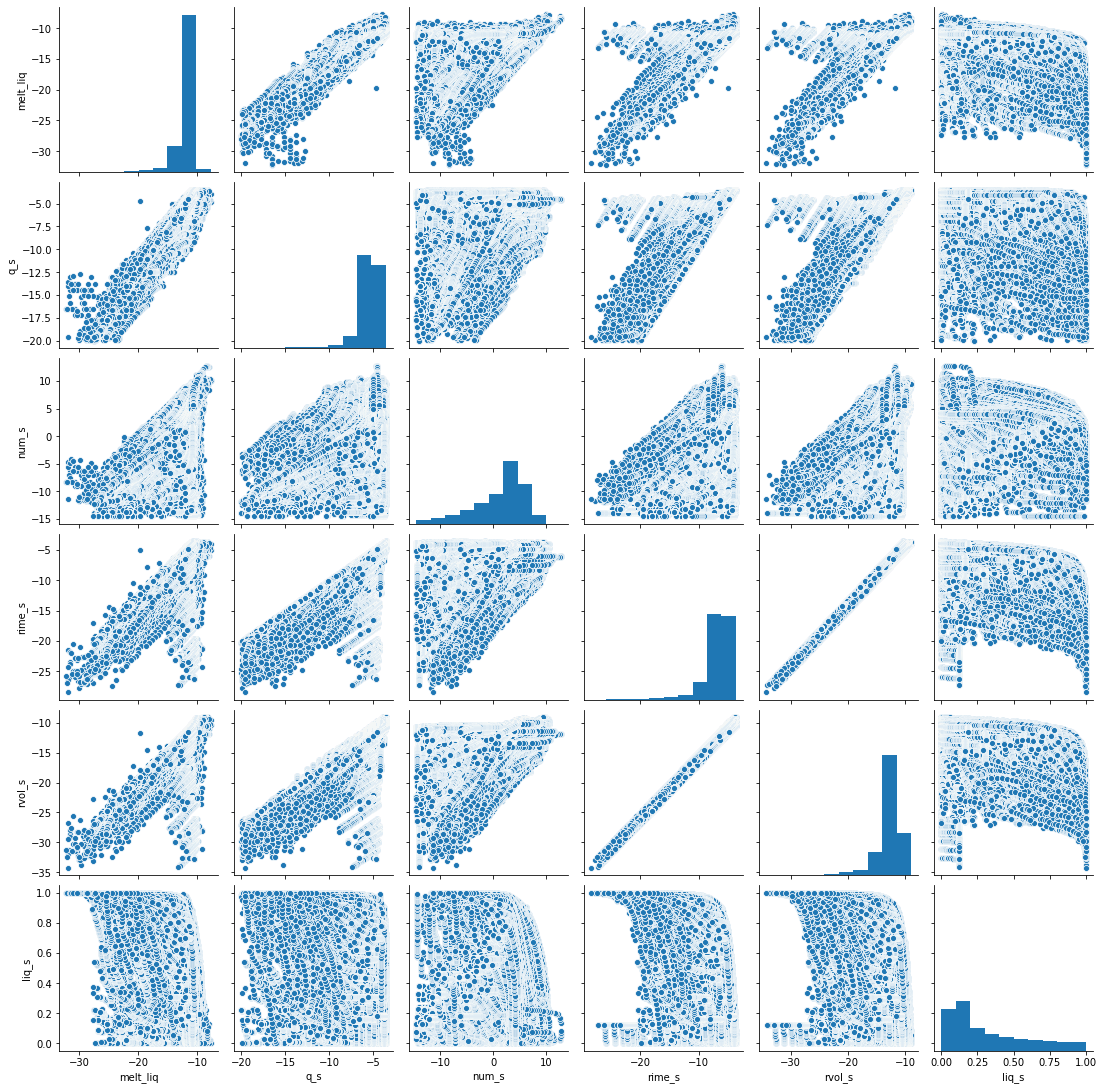

In [18]:
sns.pairplot(dataset_train[["melt_liq","q_s","num_s","rime_s","rvol_s","liq_s"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [22]:
#train_dataset1 = train_dataset1.drop(['temp'], axis=1)
#train_dataset2 = train_dataset2.drop(['rho'], axis=1)
#train_dataset3 = train_dataset3.drop(['rho'], axis=1)

In [23]:
#test_dataset1 = test_dataset1.drop(['temp'], axis=1)
#test_dataset2 = test_dataset2.drop(['rho'], axis=1)
#test_dataset3 = test_dataset3.drop(['rho'], axis=1)

In [24]:
#val_dataset1 = val_dataset1.drop(['temp'], axis=1)
#val_dataset2 = val_dataset2.drop(['rho'], axis=1)
#val_dataset3 = val_dataset3.drop(['rho'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("melt_liq")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std           min        25%        50%  \
q_s     810109.0  -5.591214  1.540329 -1.999872e+01  -5.979417  -5.314914   
num_s   810109.0   1.213460  4.882994 -1.449861e+01  -1.452691   2.832802   
rime_s  810109.0  -6.824938  2.325741 -2.838990e+01  -7.529214  -6.362644   
rvol_s  810109.0 -12.954211  2.218779 -3.424216e+01 -13.503038 -12.460861   
liq_s   810109.0   0.322870  0.276826  3.738598e-07   0.121327   0.221347   

              75%        max  
q_s     -4.774252  -3.506558  
num_s    4.587698  12.783304  
rime_s  -5.389293  -3.594406  
rvol_s -11.681273  -9.040767  
liq_s    0.506352   0.999962

In [26]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("melt_liq")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std           min        25%        50%  \
q_s     810109.0  -5.591214  1.540329 -1.999872e+01  -5.979417  -5.314914   
num_s   810109.0   1.213460  4.882994 -1.449861e+01  -1.452691   2.832802   
rime_s  810109.0  -6.824938  2.325741 -2.838990e+01  -7.529214  -6.362644   
rvol_s  810109.0 -12.954211  2.218779 -3.424216e+01 -13.503038 -12.460861   
liq_s   810109.0   0.322870  0.276826  3.738598e-07   0.121327   0.221347   

              75%        max  
q_s     -4.774252  -3.506558  
num_s    4.587698  12.783304  
rime_s  -5.389293  -3.594406  
rvol_s -11.681273  -9.040767  
liq_s    0.506352   0.999962

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [27]:
# pop does not work for multiple columns, use copy instead

labels = ['melt_liq']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [28]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [29]:
train_labels.describe()

melt_liq
count  810109.000000
mean      -12.041083
std         1.696488
min       -32.237480
25%       -12.291703
50%       -11.660660
75%       -11.220403
max        -7.722190

In [30]:
train_dataset1.describe()

q_s          num_s         rime_s         rvol_s  \
count  810109.000000  810109.000000  810109.000000  810109.000000   
mean       -5.591214       1.213460      -6.824938     -12.954211   
std         1.540329       4.882994       2.325741       2.218779   
min       -19.998716     -14.498609     -28.389902     -34.242161   
25%        -5.979417      -1.452691      -7.529214     -13.503038   
50%        -5.314914       2.832802      -6.362644     -12.460861   
75%        -4.774252       4.587698      -5.389293     -11.681273   
max        -3.506558      12.783304      -3.594406      -9.040767   

              liq_s  
count  8.101090e+05  
mean   3.228695e-01  
std    2.768256e-01  
min    3.738598e-07  
25%    1.213273e-01  
50%    2.213475e-01  
75%    5.063518e-01  
max    9.999619e-01

In [31]:
train_dataset2.describe()

q_s          num_s         rime_s         rvol_s  \
count  810109.000000  810109.000000  810109.000000  810109.000000   
mean       -5.591214       1.213460      -6.824938     -12.954211   
std         1.540329       4.882994       2.325741       2.218779   
min       -19.998716     -14.498609     -28.389902     -34.242161   
25%        -5.979417      -1.452691      -7.529214     -13.503038   
50%        -5.314914       2.832802      -6.362644     -12.460861   
75%        -4.774252       4.587698      -5.389293     -11.681273   
max        -3.506558      12.783304      -3.594406      -9.040767   

              liq_s  
count  8.101090e+05  
mean   3.228695e-01  
std    2.768256e-01  
min    3.738598e-07  
25%    1.213273e-01  
50%    2.213475e-01  
75%    5.063518e-01  
max    9.999619e-01

### Normalize the features

In [32]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)

In [33]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
q_s     810109.0  1.086322e-07  1.0 -9.353522 -0.252026  0.179377  0.530381   
num_s   810109.0  1.647156e-08  1.0 -3.217712 -0.546007  0.331629  0.691018   
rime_s  810109.0  4.809932e-08  1.0 -9.272300 -0.302818  0.198773  0.617285   
rvol_s  810109.0  3.172161e-07  1.0 -9.594445 -0.247356  0.222352  0.573711   
liq_s   810109.0 -9.421276e-08  1.0 -1.166327 -0.728047 -0.366737  0.662808   

             max  
q_s     1.353383  
num_s   2.369416  
rime_s  1.389034  
rvol_s  1.763783  
liq_s   2.445916

In [34]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
q_s     810109.0  1.086322e-07  1.0 -9.353522 -0.252026  0.179377  0.530381   
num_s   810109.0  1.647156e-08  1.0 -3.217712 -0.546007  0.331629  0.691018   
rime_s  810109.0  4.809932e-08  1.0 -9.272300 -0.302818  0.198773  0.617285   
rvol_s  810109.0  3.172161e-07  1.0 -9.594445 -0.247356  0.222352  0.573711   
liq_s   810109.0 -9.421276e-08  1.0 -1.166327 -0.728047 -0.366737  0.662808   

             max  
q_s     1.353383  
num_s   2.369416  
rime_s  1.389034  
rvol_s  1.763783  
liq_s   2.445916

### Normalize the labels

In [35]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean       std       min        25%       50%  \
melt_liq  810109.0 -12.041083  1.696488 -32.23748 -12.291703 -11.66066   

                75%      max  
melt_liq -11.220403 -7.72219

In [36]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [37]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [38]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(5,16,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [40]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.85877025],
       [-0.858426  ],
       [-0.8582768 ],
       [-0.85810316],
       [-0.85790485],
       [-0.8571615 ],
       [-0.8568648 ],
       [-0.856545  ],
       [-0.85620093],
       [-0.855445  ]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [41]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [42]:
activ = "ReLU"
model1 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0102,  mae:0.0530,  mse:0.0102,  val_loss:0.0046,  val_mae:0.0336,  val_mse:0.0046,  
............................................

Text(0, 0.5, 'MAE')

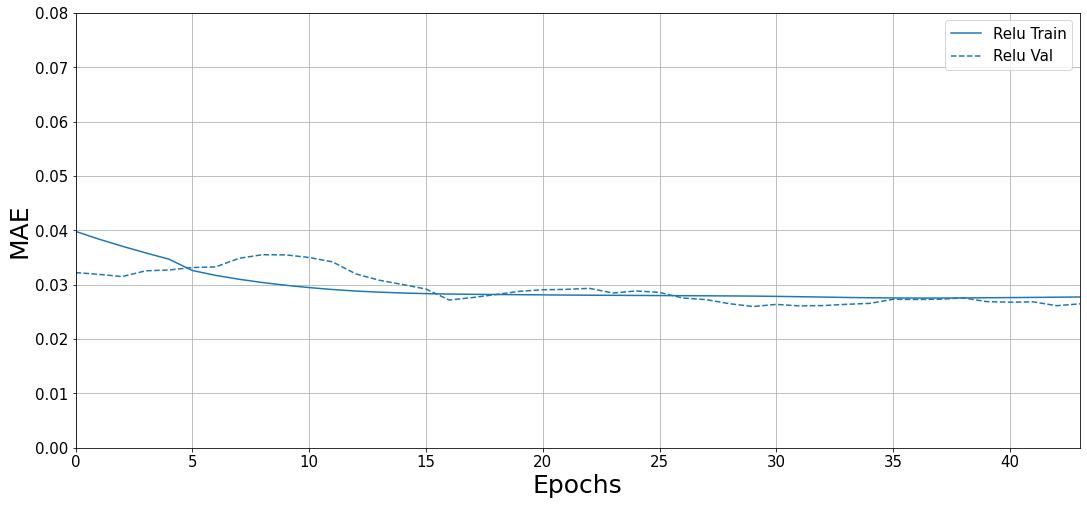

In [43]:
histories['ReLU'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.08])
plt.ylabel('MAE')

In [44]:
activ = "ReLU_Adam"
model2 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0081,  mae:0.0500,  mse:0.0081,  val_loss:0.0050,  val_mae:0.0398,  val_mse:0.0050,  
........................................

Text(0, 0.5, 'MAE')

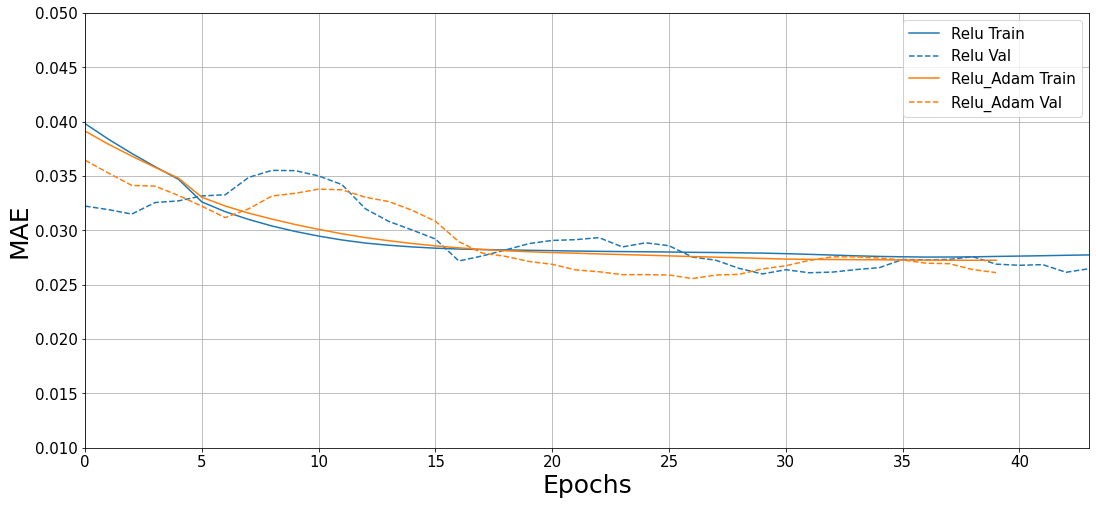

In [45]:
histories['ReLU_Adam'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.01, 0.05])
plt.ylabel('MAE')

In [46]:
nsize=32
activ = "ReLU"
model3 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0075,  mae:0.0479,  mse:0.0075,  val_loss:0.0043,  val_mae:0.0327,  val_mse:0.0043,  
...........................

Text(0, 0.5, 'MAE')

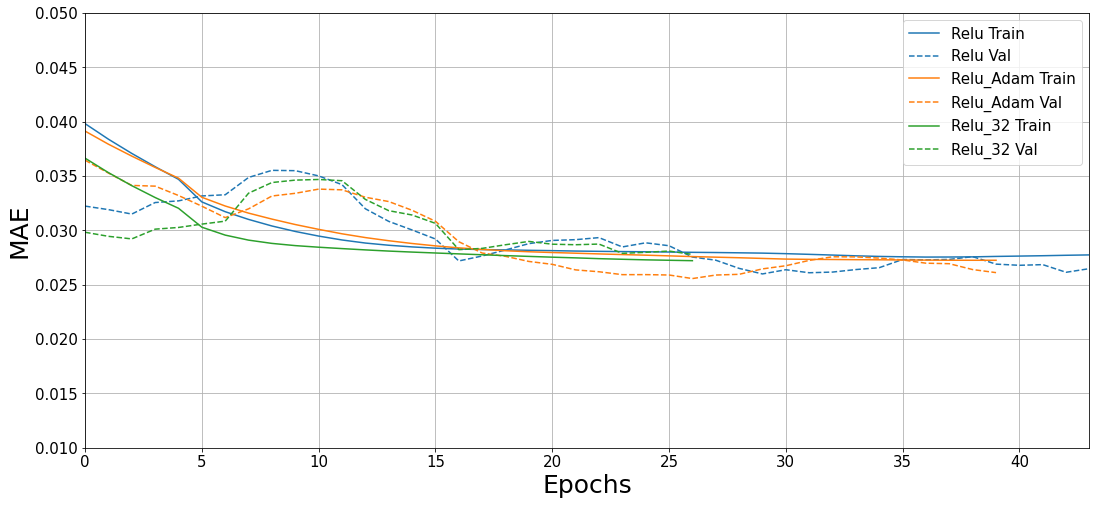

In [47]:
histories['ReLU_32'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.01, 0.05])
plt.ylabel('MAE')

In [48]:
activ = "ReLU_Adam"
model4 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0068,  mae:0.0452,  mse:0.0068,  val_loss:0.0039,  val_mae:0.0312,  val_mse:0.0039,  
..............................................................

Text(0, 0.5, 'MAE')

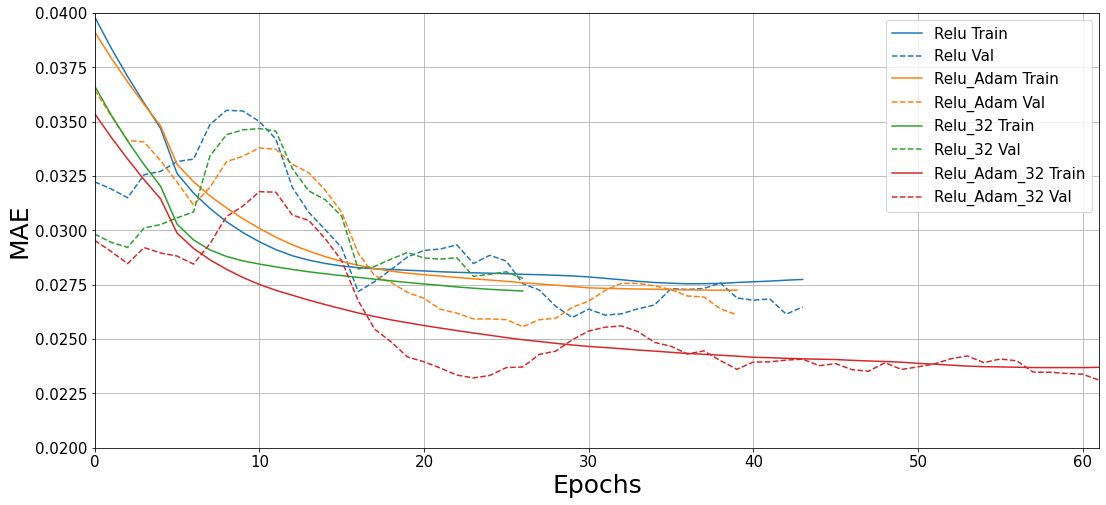

In [49]:
histories['ReLU_Adam_32'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.02, 0.04])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

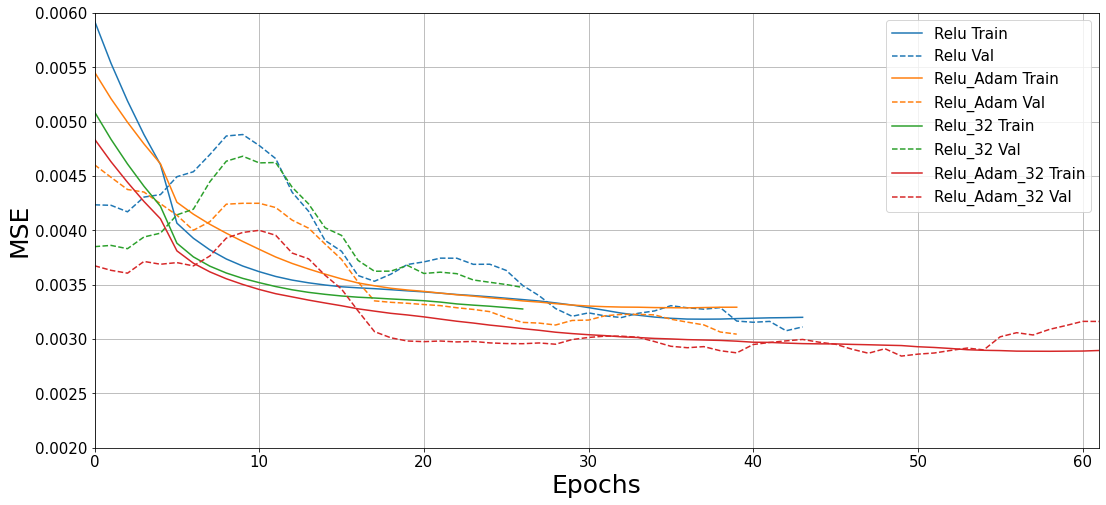

In [50]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mse")
plt.ylim([0.002, 0.006])
plt.ylabel('MSE')

In [51]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:20.5f}".format(mae1))

173193/173193 - 4s - loss: 0.0027 - mae: 0.0227 - mse: 0.0027
Testing set for model 1, Mean Abs Error:              0.02271


In [52]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

173193/173193 - 4s - loss: 0.0030 - mae: 0.0266 - mse: 0.0030
Testing set for model 2, Mean Abs Error:              0.02657


In [53]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

173193/173193 - 4s - loss: 0.0030 - mae: 0.0234 - mse: 0.0030
Testing set for model 3, Mean Abs Error:              0.02337


In [54]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

173193/173193 - 4s - loss: 0.0027 - mae: 0.0223 - mse: 0.0027
Testing set for model 4, Mean Abs Error:              0.02230


In [55]:
mae = [ mae1, mae2, mae3, mae4 ]
mae

[0.022709219, 0.026571302, 0.023367172, 0.02229552]

In [56]:
mse = [ mse1, mse2, mse3, mse4 ]
mse

[0.0027314979, 0.002985374, 0.0029883047, 0.0026919176]

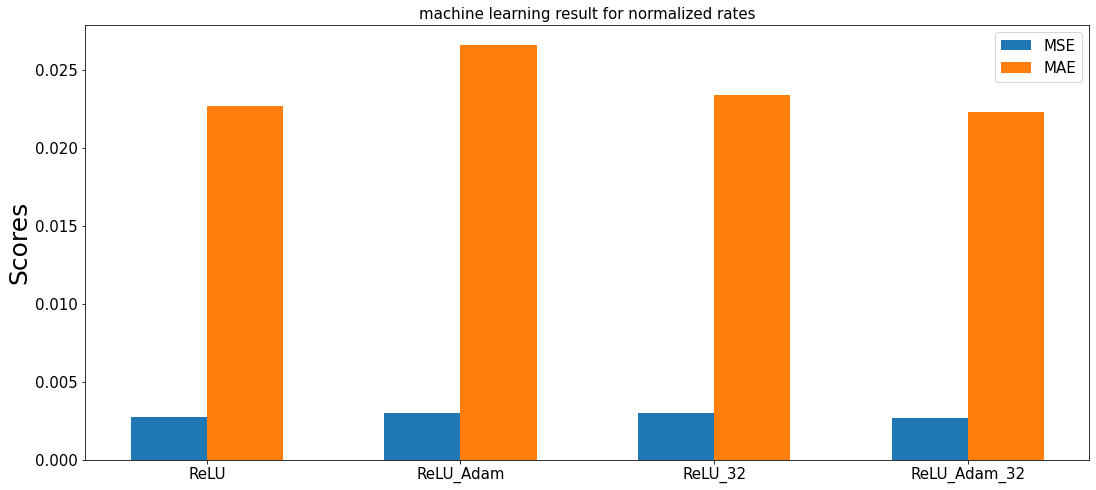

In [57]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = [
 'ReLU',
 'ReLU_Adam',
 'ReLU_32',
 'ReLU_Adam_32' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized rates')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [58]:
test_true_liq  = np.exp(test_labels.pop('melt_liq'))

In [59]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [60]:
labels = [ "melt_liq" ]

In [61]:
p2 = pd.DataFrame(data=model2.predict(normed_test_data2), columns=labels)

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_liq   = test_predict2['melt_liq']

In [62]:
p4 = pd.DataFrame(data=model4.predict(normed_test_data2), columns=labels)

test_predict4 = np.exp(backtransform(p4,train_labels_stats))

test_predict4_liq   = test_predict4['melt_liq']

In [63]:
amin, amax = 1e-10, 1e-3

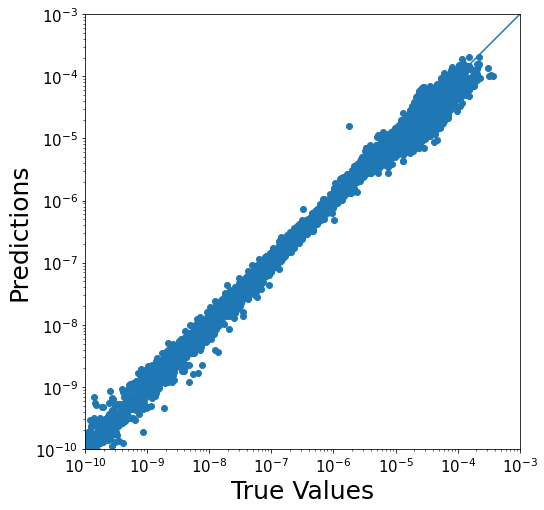

In [64]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_liq, test_predict2_liq)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

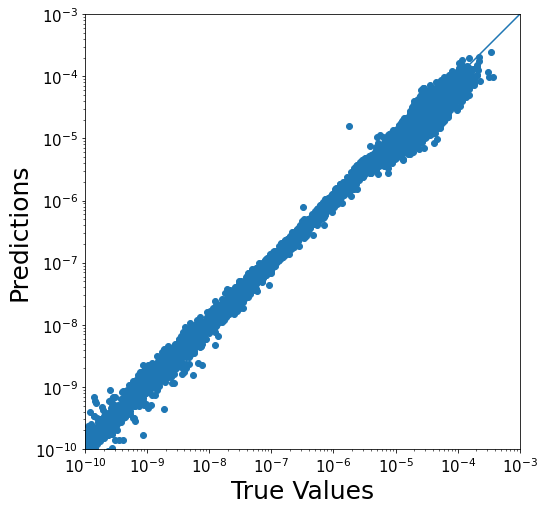

In [65]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_liq, test_predict4_liq)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [66]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
version

'16'

In [67]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [68]:
features = 'q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liq_fraction'
labels   = 'melt_liq'
logtransform = np.array([True, True, True, True, False], dtype=bool)

In [69]:
filename = 'saved_model_v2/melt_rimedsnow_model1_'+version+'.nc'
save2netcdf(model1,features,labels,train_stats2,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/melt_rimedsnow_model2_'+version+'.nc'
save2netcdf(model2,features,labels,train_stats2,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/melt_rimedsnow_model1_16.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liq_fraction
  Labels:     melt_liq
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (5, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/melt_rimedsnow_model2_16.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liq_fraction
  Labels:     melt_liq
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (5, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflo

In [70]:
filename = 'saved_model_v2/melt_rimedsnow_model3_'+version+'.nc'
save2netcdf(model3,features,labels,train_stats2,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/melt_rimedsnow_model4_'+version+'.nc'
save2netcdf(model4,features,labels,train_stats2,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/melt_rimedsnow_model3_16.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liq_fraction
  Labels:     melt_liq
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (5, 32), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (32, 32), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (32, 32), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (32, 1), Activation: linear
Saving model to saved_model_v2/melt_rimedsnow_model4_16.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liq_fraction
  Labels:     melt_liq
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (5, 32), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (32, 32), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (32, 32), Activation: relu
  Layer 3: <class 'tensorflo

In [71]:
train_stats2

count       mean       std           min        25%        50%  \
q_s     810109.0  -5.591214  1.540329 -1.999872e+01  -5.979417  -5.314914   
num_s   810109.0   1.213460  4.882994 -1.449861e+01  -1.452691   2.832802   
rime_s  810109.0  -6.824938  2.325741 -2.838990e+01  -7.529214  -6.362644   
rvol_s  810109.0 -12.954211  2.218779 -3.424216e+01 -13.503038 -12.460861   
liq_s   810109.0   0.322870  0.276826  3.738598e-07   0.121327   0.221347   

              75%        max  
q_s     -4.774252  -3.506558  
num_s    4.587698  12.783304  
rime_s  -5.389293  -3.594406  
rvol_s -11.681273  -9.040767  
liq_s    0.506352   0.999962